In [1]:
import sys
sys.path.insert(1, 'utils')
from utils import *
from data_manipulation import *
pd.options.display.max_colwidth = 100

In [2]:
dataset = pd.read_csv('data/training_data.csv')

### Un vistazo a las features

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5930 entries, 0 to 5929
Data columns (total 78 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                5930 non-null   object 
 1   site_id                           5930 non-null   object 
 2   title                             5930 non-null   object 
 3   seller                            5930 non-null   object 
 4   price                             5930 non-null   float64
 5   prices                            5927 non-null   object 
 6   sale_price                        0 non-null      float64
 7   currency_id                       5930 non-null   object 
 8   available_quantity                5930 non-null   int64  
 9   sold_quantity                     5930 non-null   int64  
 10  buying_mode                       5930 non-null   object 
 11  listing_type_id                   5930 non-null   object 
 12  stop_t

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [5]:
from sklearn.model_selection import train_test_split

### Un poco de limpieza

In [6]:
dataset['warrant_time'] = dataset.warrant_time.fillna(0)
dataset['seller_status'] = dataset.seller_status.fillna('N/A')

dataset.dropna(subset=['initial_quantity', 'created_date_diff_decile', 'last_update_diff_decile'], inplace=True)
dataset.reset_index(drop=True, inplace=True)

#### One Hot Encoding para las Variables categorícas

In [7]:
seller_status_columns = ["seller_status_{}".format(idx) for idx,_val in enumerate(dataset.seller_status.unique())]
pub_condition_columns = ["pub_condition_{}".format(idx) for idx,_val in enumerate(dataset.condition.unique())]

In [8]:
one_hot_encoder = OneHotEncoder(sparse=False)
ohc = one_hot_encoder.fit_transform(dataset['seller_status'].values.reshape(-1,1))
dataset = pd.concat([dataset, pd.DataFrame(ohc, columns=seller_status_columns)], axis=1)

In [9]:
one_hot_encoder = OneHotEncoder(sparse=False, )
ohc = one_hot_encoder.fit_transform(dataset['condition'].values.reshape(-1,1))
dataset = pd.concat([dataset, pd.DataFrame(ohc, columns=pub_condition_columns)], axis=1).reindex(dataset.index)

## __Selección de features__

In [10]:
features = ['price', 'available_quantity', 'initial_quantity', 'discount_per', 'installment_num', 'installment_rate', 
            'pic_qty', 'created_date_diff', 'created_date_diff_decile','last_update_diff_decile', 'has_free_shipping',
            'last_update_date_diff', 'warrant_time', 'is_official', 'has_video', 'qty_variations', 'qty_attributes'] +  seller_status_columns + pub_condition_columns

predictors = dataset[features]
predictors.isnull().any()

price                       False
available_quantity          False
initial_quantity            False
discount_per                False
installment_num             False
installment_rate            False
pic_qty                     False
created_date_diff           False
created_date_diff_decile    False
last_update_diff_decile     False
has_free_shipping           False
last_update_date_diff       False
warrant_time                False
is_official                 False
has_video                   False
qty_variations              False
qty_attributes              False
seller_status_0             False
seller_status_1             False
seller_status_2             False
seller_status_3             False
pub_condition_0             False
pub_condition_1             False
pub_condition_2             False
dtype: bool

In [11]:
predictors.describe()

,price,available_quantity,initial_quantity,discount_per,installment_num,installment_rate,pic_qty,created_date_diff,created_date_diff_decile,last_update_diff_decile,...,has_video,qty_variations,qty_attributes,seller_status_0,seller_status_1,seller_status_2,seller_status_3,pub_condition_0,pub_condition_1,pub_condition_2
count,5.929000e+03,5929.000000,5929.000000,5929.000000,5929.000000,5929.000000,5929.000000,5929.000000,5929.000000,5929.000000,...,5929.000000,5929.000000,5929.000000,5929.000000,5929.000000,5929.000000,5929.000000,5929.000000,5929.000000,5929.000000
mean,6.311270e+04,255.989712,460.749199,1.862709,11.641255,49.920233,5.505144,239.269691,5.508855,5.508855,...,0.071007,0.662169,5.573959,0.302749,0.064260,0.573284,0.059707,0.818519,0.000169,0.181312
std,1.481851e+05,3007.911347,4640.840901,6.317380,3.006121,31.796912,3.875511,321.591994,2.877790,2.877790,...,0.256858,0.702358,1.686246,0.459486,0.245237,0.494642,0.236962,0.385449,0.012987,0.385309
min,3.300000e+01,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,1.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.038900e+04,1.000000,3.000000,0.000000,12.000000,0.000000,3.000000,49.000000,3.000000,3.000000,...,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,4.649900e+04,1.000000,13.000000,0.000000,12.000000,70.170000,5.000000,123.000000,6.000000,6.000000,...,0.000000,1.000000,5.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,7.799900e+04,1.000000,58.000000,0.000000,12.000000,70.170000,7.000000,258.000000,8.000000,8.000000,...,0.000000,1.000000,7.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,9.999999e+06,50000.000000,101174.000000,43.000000,18.000000,70.170000,50.000000,1903.000000,10.000000,10.000000,...,1.000000,6.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## __Test Train Split__

### Se tomará 20% de los datos para validación

In [12]:
target = dataset['sold_quantity']
x_train, x_cv, y_train, y_cv = train_test_split(predictors, target, test_size=0.2, random_state=1)

# __Modelos__

### Cómo se trata de un problema de regresión donde tengo el target que quiero predecir, voy a utilizar modelos de tipo arbol y regresiones lineales pues estos generalmente dan buenos resultados inclusive con poca cantidad de features o la poca cantidad de datos utilizados, los modelos a comparar serán:
* Gradient Boosting
* Random Forest
* Lasso (Regresión lineal con regularización Lasso)
* KNN

### Cómo medida de performance, voy a usar __R²__ para medir la performance del modelo, dado que este valor permite conocer que tanta dispersión hay en la variable independiente respecto de las variables independientes. Para comparar distintos modelos ademas voy a usar el __RMSE__. 

# Gradient Boosting

### Voy a probar múltiples parámetros para encontrar el óptimo, solo con gradient boosting, pues es el que mejores resultados presento en comparación con los demás

In [13]:
rmse_models = []

In [14]:
params = [{'max_depth': [3,10,20], 'learning_rate': [0.0001, 0.01, 0.1, 0.5], 'n_estimators': [100, 150, 200, 250]}]

gb = GridSearchCV(GradientBoostingRegressor(), params, cv=3)
gb.fit(x_train, y_train)
y_pred_gb = gb.predict(x_cv)
gb_r2 = r2_score(y_cv, y_pred_gb)
gb_mse = mean_squared_error(y_cv, y_pred_gb)
gb_rmse = math.sqrt(gb_mse)
rmse_models.append(['Gradient Boost', gb_rmse])
print("R²: {}\nMSE: {}\nRMSE: {}".format(gb_r2, gb_mse, gb_rmse ))

R²: 0.8834675267672856
MSE: 10352.121518049726
RMSE: 101.74537590499986


## Los parámetros elegidos son:

In [15]:
gb.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}

# Random Forest

In [16]:
rf = RandomForestRegressor(n_estimators=200)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_cv)
rf_r2 = r2_score(y_cv, y_pred_rf)
rf_mse = mean_squared_error(y_cv, y_pred_rf)
rf_rmse = math.sqrt(rf_mse)
rmse_models.append(['Random Forest', rf_rmse])
print("R²: {}\nMSE: {}\nRMSE: {}".format(rf_r2, rf_mse, rf_rmse ))

R²: 0.8100298686477433
MSE: 16875.930202143376
RMSE: 129.90739086804638


# Lasso

In [17]:
lso = RandomForestRegressor(n_estimators=200)
lso.fit(x_train, y_train)
y_pred_lso = lso.predict(x_cv)
lso_r2 = r2_score(y_cv, y_pred_lso)
lso_mse = mean_squared_error(y_cv, y_pred_lso)
lso_rmse = math.sqrt(lso_mse)
rmse_models.append(['Lasso', lso_rmse])
print("R²: {}\nMSE: {}\nRMSE: {}".format(lso_r2, lso_mse, lso_rmse ))

R²: 0.7925592122879541
MSE: 18427.929851850055
RMSE: 135.74951142398285


# KNN

In [18]:
knn = KNeighborsRegressor()
knn.fit(x_train, y_train)
y_pred_knn = knn.predict(x_cv)
knn_r2 = r2_score(y_cv, y_pred_knn)
knn_mse = mean_squared_error(y_cv, y_pred_knn)
knn_rmse = math.sqrt(knn_mse)
rmse_models.append(['KNN', knn_rmse])
print("R²: {}\nMSE: {}\nRMSE: {}".format(knn_r2, knn_mse, knn_rmse ))

R²: 0.4059313980350522
MSE: 52773.876559865086
RMSE: 229.72565498843417


## __Resultados__

In [19]:
test_set = pd.concat([x_cv, y_cv], axis=1)
test_set['y_pred'] = y_pred_gb
test_set = test_set.join(pd.DataFrame(dataset.category), how='left')
test_set_by_cat = test_set.groupby('category')

r2_by_cat = []
for cat, test in test_set_by_cat:
    r2_by_cat.append([cat,math.sqrt(mean_squared_error(test.sold_quantity, test.y_pred))])
r2_by_cat = pd.DataFrame(r2_by_cat, columns=['category', 'error'])

[Text(0.5, 0, 'Category'), Text(0, 0.5, 'R² Score')]

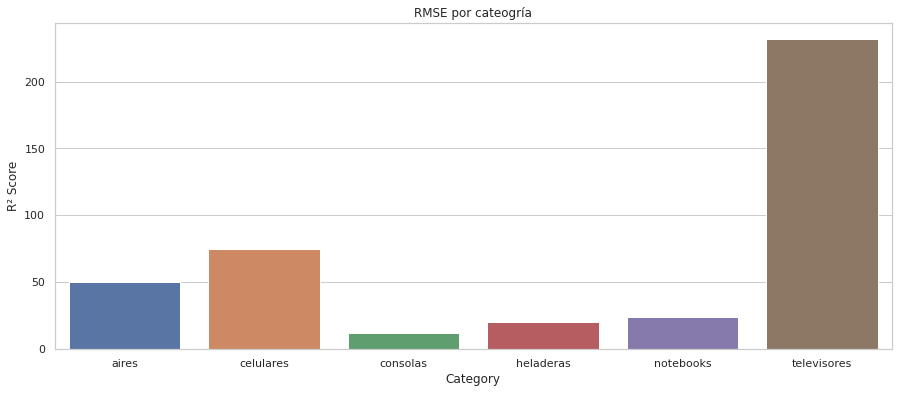

In [20]:
plt.figure(figsize = (15, 6))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="category", y="error", data=r2_by_cat)
ax.set_title("RMSE por cateogría")
ax.set(xlabel='Category', ylabel='R² Score')

### Viendo el error cuadrático medio para las distintas categorías se puede ver que el modelo comete muchos errores al predecir la cantidad vendida de televisores en comparación con las otras categorías

## __Comparando Modelos__

[Text(0.5, 0, 'Category'), Text(0, 0.5, 'RMSE')]

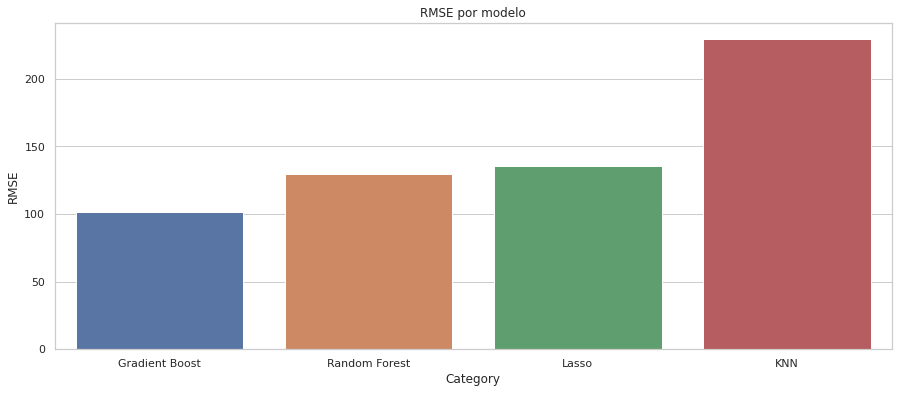

In [21]:
rmse_mod = pd.DataFrame(rmse_models, columns=['model', 'RMSE'])

plt.figure(figsize = (15, 6))
ax = sns.barplot(data=rmse_mod, x="model", y="RMSE")
ax.set_title("RMSE por modelo")
ax.set(xlabel='Category', ylabel='RMSE')

## Gráfico de los residuos para algunas features

#### Calculo de residuo estandarizado

In [22]:
test_set['residual'] = test_set.sold_quantity - test_set.y_pred
mean_residual = test_set.residual.mean()
std_residual = test_set.residual.std()
test_set['standard_residual'] = (test_set.residual - mean_residual)/std_residual

[Text(0.5, 0, 'Price'), Text(0, 0.5, 'Residuo estandarizado')]

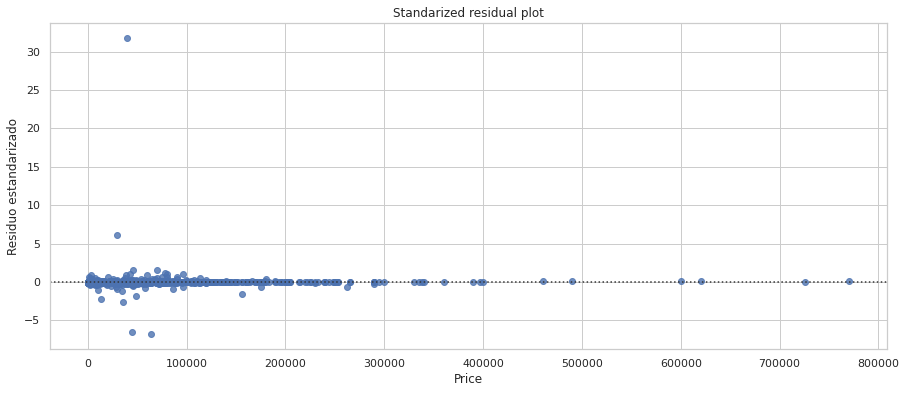

In [23]:
plt.figure(figsize = (15, 6))
ax = sns.residplot(data=test_set, x='price', y='standard_residual')
ax.set_title("Standarized residual plot")
ax.set(xlabel='Price', ylabel='Residuo estandarizado')

[Text(0.5, 0, 'initial_quantity'), Text(0, 0.5, 'Residuo estandarizado')]

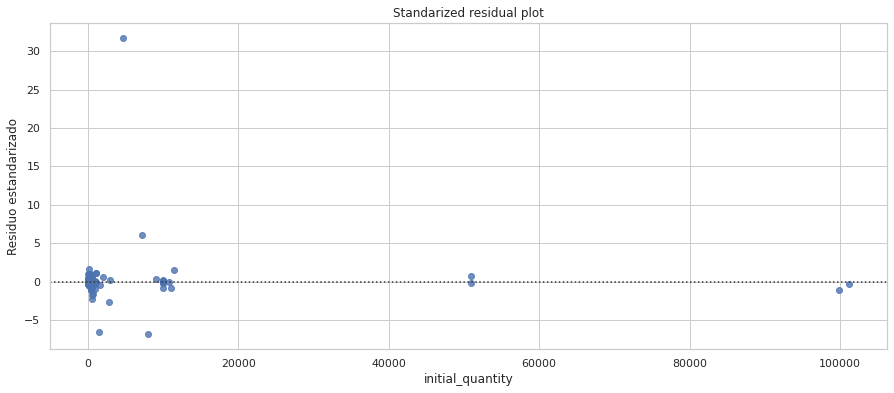

In [24]:
plt.figure(figsize = (15, 6))
ax = sns.residplot(data=test_set, x='initial_quantity', y='standard_residual')
ax.set_title("Standarized residual plot")
ax.set(xlabel='initial_quantity', ylabel='Residuo estandarizado')

[Text(0.5, 0, 'is_official'), Text(0, 0.5, 'Residuo estandarizado')]

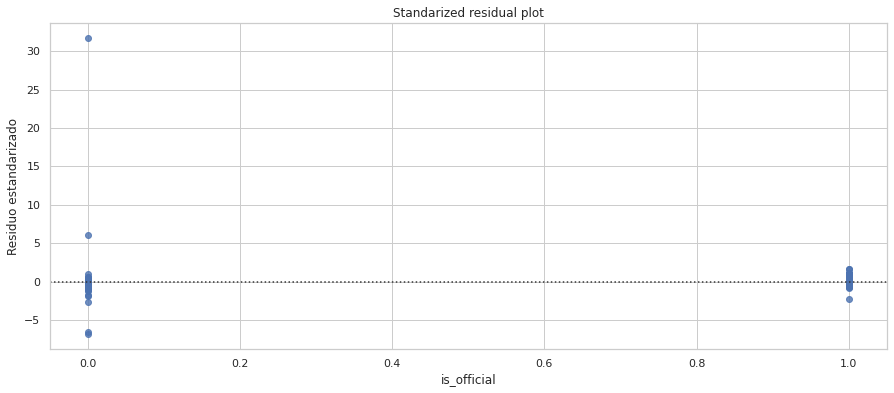

In [25]:
plt.figure(figsize = (15, 6))
ax = sns.residplot(data=test_set, x='is_official', y='standard_residual')
ax.set_title("Standarized residual plot")
ax.set(xlabel='is_official', ylabel='Residuo estandarizado')

### __Feature Importances Gradient Boost__

### Para ver un poco como se comportaron las features del Gradient Boost, calculo el feature importance y estas podrán apreciarse en la siguiente visualización

In [26]:
importances = list(gb.best_estimator_.feature_importances_)

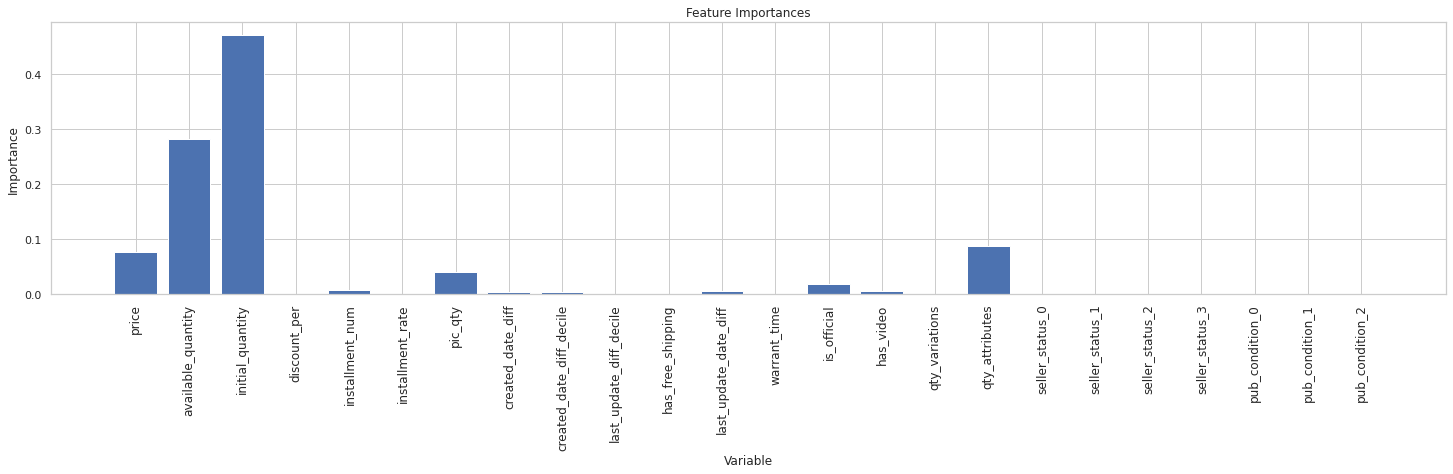

In [27]:
fig = plt.figure(figsize=(25, 5))
ax = fig.add_subplot(111)
x_values = list(range(len(importances)))
ax.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, features, rotation='vertical', fontsize=12)
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Feature Importances');
